In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
import shap
from sklearn.metrics import ConfusionMatrixDisplay, DetCurveDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

In [30]:
shap.initjs()

In [31]:
df = pd.read_csv('tyg3.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_ercp,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,14.130556,0,0,0,0,0,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,15.834722,0,0,0,0,0,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,21.834722,0,0,0,0,0,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,9.019225,17.736806,0,0,0,0,0,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,10.655556,0,0,0,0,0,0


In [32]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y'],
      dtype='object')

In [33]:
df['gender'] = df['gender'].map({'F': 0, 'M': 1})

In [34]:
cols = ['age',
       'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine','alt', 'alp',
       'ast', 'pt', 'ptt', 'inr','tyg']

In [35]:
imp = IterativeImputer(max_iter=1000, random_state=2026)
df[cols] = imp.fit_transform(df[cols])

In [36]:
cols_scale = ['age',
       'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine','alt', 'alp',
       'ast', 'pt', 'ptt', 'inr','tyg']

In [37]:
scaler = MaxAbsScaler()
df[cols_scale] = scaler.fit_transform(df[cols_scale])

In [38]:
X, y = df[cols], df['mortality_28d']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2026)

In [40]:
lg = LogisticRegression(max_iter=500)
lg.fit(X_train, y_train)
lg.score(X_test, y_test)

0.8493975903614458

In [41]:
lg.coef_.shape, X.columns

((1, 19),
 Index(['age', 'wbc', 'rbc', 'rdw', 'hemoglobin', 'platelets', 'aniongap',
        'bicarbonate', 'calcium', 'chloride', 'potassium', 'creatinine', 'alt',
        'alp', 'ast', 'pt', 'ptt', 'inr', 'tyg'],
       dtype='object'))

In [42]:
df_coef = pd.DataFrame({
    'features': X.columns,
    'coef': lg.coef_.flatten()
})
df_coef['coef_abs'] = df_coef['coef'].abs()
df_coef.sort_values(by = 'coef_abs', ascending=False).head(10)

,features,coef,coef_abs
7,bicarbonate,-2.650378,2.650378
0,age,2.182414,2.182414
3,rdw,1.735838,1.735838
6,aniongap,1.434195,1.434195
4,hemoglobin,-1.351721,1.351721
11,creatinine,0.989488,0.989488
15,pt,0.624735,0.624735
8,calcium,-0.524690,0.524690
16,ptt,0.475258,0.475258
10,potassium,0.412919,0.412919


In [43]:
explainer = shap.Explainer(model=lg, masker=X_train, feature_names=X_train.columns)
shap_values = explainer(X_test)
shap_values.shape

(166, 19)

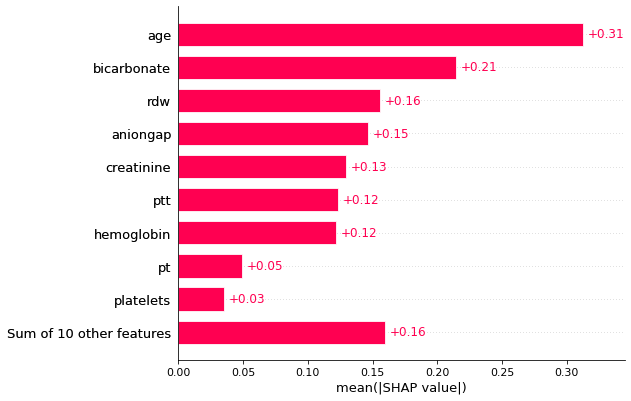

In [44]:
shap.plots.bar(shap_values)

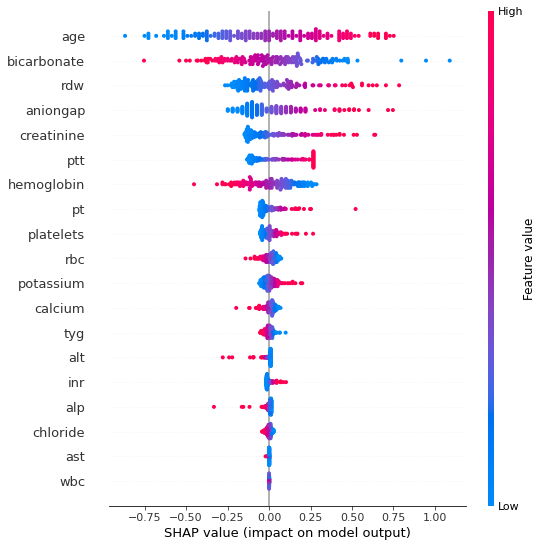

In [63]:
shap.plots.beeswarm(shap_values, max_display=1000)


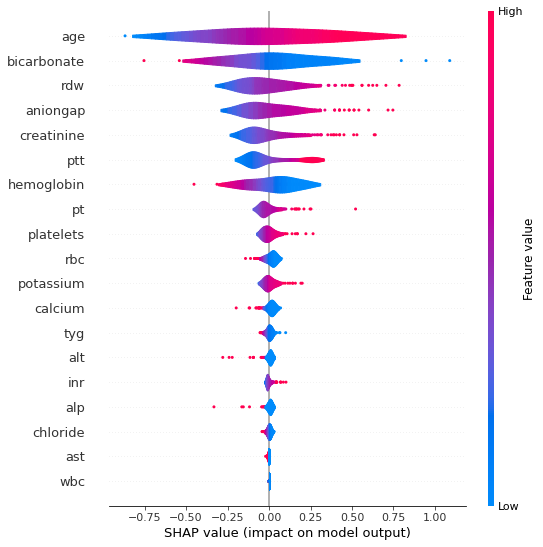

In [46]:
shap.plots.violin(shap_values)

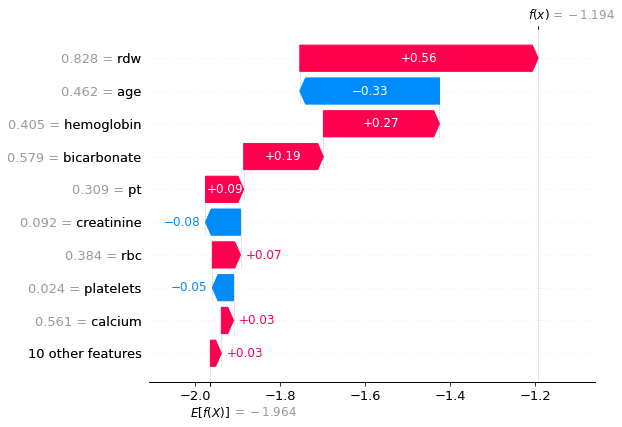

In [47]:
shap.plots.waterfall(shap_values[2])

In [48]:
ind = 0
shap.plots.force(shap_values[ind])

In [49]:
lgcv = RandomForestClassifier(random_state=2026)
lgcv.fit(X_train,y_train)
lgcv.score(X_test, y_test)

0.891566265060241

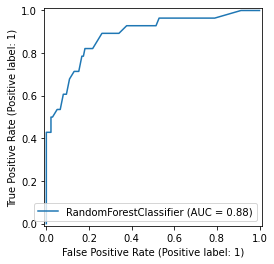

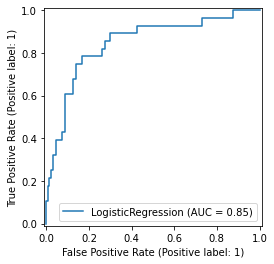

In [50]:
RocCurveDisplay.from_estimator(lgcv, X = X_test, y=y_test)
RocCurveDisplay.from_estimator(lg, X=X_test, y = y_test)

In [51]:
rfc = RandomForestClassifier(random_state=2026)
rfc.fit(X_train,y_train)
rfc.score(X_test, y_test)

0.891566265060241

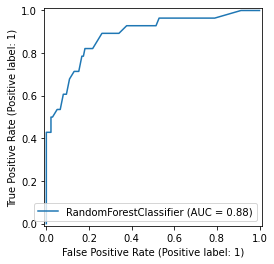

In [52]:
RocCurveDisplay.from_estimator(rfc, X=X_test, y = y_test)

In [53]:
explainer = shap.Explainer(model=lg, masker=X_train)
shap_values = explainer(X_test)
shap_values.shape

(166, 19)

In [54]:
explainer = shap.Explainer(model=rfc, masker=X_train)
shap_values = explainer(X_test)
shap_values.shape

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.920200, while the model output was 0.940000. If this difference is acceptable you can set check_additivity=False to disable this check.

<Axes: xlabel='importances', ylabel='features'>

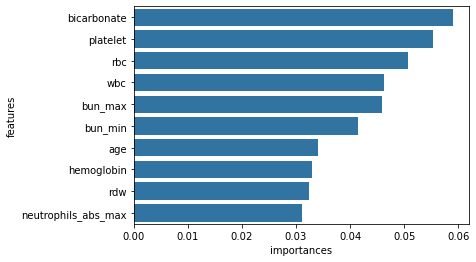

In [ ]:
import seaborn as sns
df_imp = pd.DataFrame({
    'features': X_train.columns,
    'importances': rfc.feature_importances_
}).sort_values(by='importances', ascending=False).head(10)

sns.barplot(df_imp, y='features', x='importances')


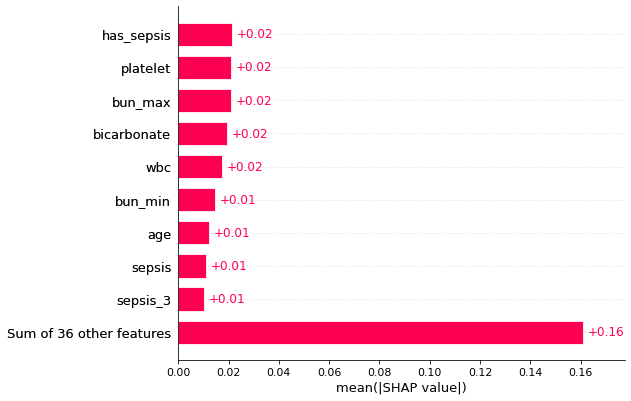

In [ ]:
shap.plots.bar(shap_values[:, :, 1])

In [ ]:
shap.plots.force(shap_values[0, :, 1])

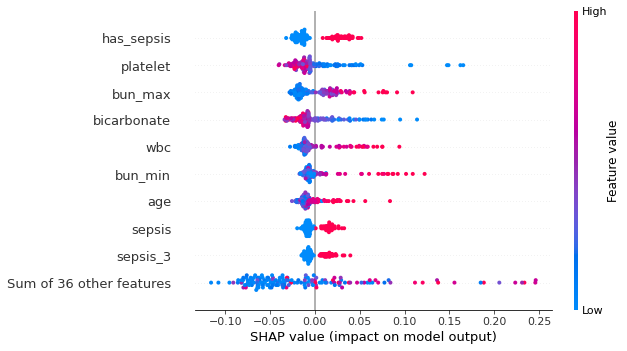

In [ ]:
shap.plots.beeswarm(shap_values[..., 1])